In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os 

# Load MNIST data
(original_train_images, original_train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape the entire dataset before splitting
normalized_images = original_train_images.reshape(original_train_images.shape[0], -1).astype('float32') / 255

# Define a split ratio for the dataset
split_ratio = 0.8  # e.g., 80% for training, 20% for validation / testing

# Calculate the number of images to include in the training set
num_train_images = int(len(normalized_images) * split_ratio)

# Split the images and labels into training and test sets
train_images = normalized_images[:num_train_images]
train_labels = original_train_labels[:num_train_images]
val_images = normalized_images[num_train_images:]
val_labels = original_train_labels[num_train_images:]

# Create a TensorFlow dataset for each digit in the training set
datasets = []
for digit in range(10):
    idx = train_labels == digit
    digit_images = train_images[idx]
    datasets.append(tf.data.Dataset.from_tensor_slices(digit_images).shuffle(1000).batch(60))

In [2]:
class GMMN(tf.keras.Model):
    def __init__(self):
        super(GMMN, self).__init__()
        # self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        # self.dense2 = tf.keras.layers.Dense(256, activation='relu')
        # self.dense3 = tf.keras.layers.Dense(512, activation='relu')
        # self.dense4 = tf.keras.layers.Dense(784, activation='sigmoid')  # MNIST images are 28x28=784 pixels
        self.dense1 = tf.keras.layers.Dense(16, activation='relu')
        self.dense2 = tf.keras.layers.Dense(16, activation='relu')
        self.dense3 = tf.keras.layers.Dense(10, activation='relu')
        self.dense4 = tf.keras.layers.Dense(784, activation='sigmoid')  # MNIST images are 28x28=784 pixels

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.dense4(x)
    
test_model = GMMN()
test_model.build(input_shape=(None, 100))
test_model.summary()



Model: "gmmn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  1616      
                                                                 
 dense_1 (Dense)             multiple                  272       
                                                                 
 dense_2 (Dense)             multiple                  170       
                                                                 
 dense_3 (Dense)             multiple                  8624      
                                                                 
Total params: 10682 (41.73 KB)
Trainable params: 10682 (41.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [3]:
def compute_kernel(x, y, sigma_list):
    """Computes a Gaussian kernel between two sets of samples using multiple bandwidth parameters."""
    beta_list = [1.0 / (2.0 * sigma**2) for sigma in sigma_list]
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.cast(tf.shape(x)[1], tf.float32)
    x_expanded = tf.expand_dims(x, 1)
    y_expanded = tf.expand_dims(y, 0)
    kernel_val = 0.
    for beta in beta_list:
        beta = tf.cast(beta, tf.float32)
        squared_diff = tf.reduce_sum(tf.square(x_expanded - y_expanded), 2)
        kernel_val += tf.exp(-beta * squared_diff)
    return kernel_val / tf.cast(tf.size(sigma_list), tf.float32)

def compute_mmd(x, y, sigma_list=[2, 5, 10, 20, 40, 80]):
    """Computes the Maximum Mean Discrepancy (MMD) between two sets of samples, x and y."""
    x_kernel = compute_kernel(x, x, sigma_list)
    y_kernel = compute_kernel(y, y, sigma_list)
    xy_kernel = compute_kernel(x, y, sigma_list)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)


In [4]:
def log_mean_exp(a):
    """Compute the log of the mean of exponentials of input elements."""
    max_ = tf.reduce_max(a, axis=1, keepdims=True)
    return max_ + tf.math.log(tf.reduce_mean(tf.exp(a - max_), axis=1))

def tensorflow_parzen_estimator(mu, sigma):
    """Constructs a Parzen window estimator using TensorFlow."""
    mu = tf.convert_to_tensor(mu, dtype=tf.float32)
    sigma = tf.constant(sigma, dtype=tf.float32)
    
    def parzen_estimator(x):
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        a = (tf.expand_dims(x, 1) - tf.expand_dims(mu, 0)) / sigma
        E = log_mean_exp(-0.5 * tf.reduce_sum(tf.square(a), axis=2))
        Z = mu.shape[1] * tf.math.log(sigma * tf.sqrt(2 * np.pi))
        return E - Z
    
    return parzen_estimator

def compute_log_likelihood(parzen, data, batch_size=100):
    """Computes log-likelihood of data given a Parzen window estimator."""
    n_batches = int(np.ceil(data.shape[0] / batch_size))
    log_likelihoods = []
    for i in range(n_batches):
        batch = data[i*batch_size:(i+1)*batch_size]
        log_likelihood = parzen(batch)
        log_likelihoods.append(log_likelihood)
    return tf.reduce_mean(log_likelihoods)

def find_best_sigma(samples, data, sigma_range, batch_size=100, verbose=True):
    """Finds the best sigma value over a range by optimizing log-likelihood."""
    best_log_likelihood = float('-inf')
    best_sigma = 0
    
    for sigma in sigma_range:
        parzen = tensorflow_parzen_estimator(samples, sigma)
        log_likelihood = compute_log_likelihood(parzen, data, batch_size)
        
        if log_likelihood > best_log_likelihood:
            best_log_likelihood = log_likelihood
            best_sigma = sigma
            
        if verbose:
            print(f'sigma={sigma}, log_likelihood={log_likelihood.numpy():.2f}')
    
    if verbose:
        print('====================')
        print(f'Best log_likelihood={best_log_likelihood.numpy():.2f} for sigma={best_sigma}')
        print('')
    
    return best_log_likelihood, best_sigma

In [5]:
models = [GMMN() for _ in range(10)]

def generate_images(model, digit, num_images=10):
    noise = tf.random.normal([num_images, 100])
    generated_images = model(noise)
    generated_images = tf.reshape(generated_images, (-1, 28, 28))

    fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
    for i, ax in enumerate(axes):
        ax.imshow(generated_images[i, :, :], cmap='gray')
        ax.axis('off')
    plt.suptitle(f'Generated Images for Digit {digit}')
    plt.show()


In [6]:
def plot_training_metrics(epochs, mmd_losses, parzen_log_likelihoods, parzen_eval_interval, target_digit):
    """
    Plots and saves the training metrics including MMD Loss and Parzen Window Log Likelihood
    for a specific target digit.
    
    Parameters:
    - epochs: Total number of epochs trained.
    - mmd_losses: List of MMD losses recorded after each epoch.
    - parzen_log_likelihoods: List of Parzen window log likelihoods recorded at specified intervals.
    - parzen_eval_interval: Interval at which Parzen window log likelihoods were evaluated.
    - target_digit: The target digit for which the model was trained.
    """
    
    # Create directory if it doesn't exist
    save_dir = f'evaluation/{target_digit}'
    os.makedirs(save_dir, exist_ok=True)
    
    plt.figure(figsize=(12, 6))
    
    # Plotting MMD Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), mmd_losses, label='MMD Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MMD Loss')
    plt.title('MMD Loss over Epochs')
    plt.legend()
    
    # Plotting Parzen Window Log Likelihood
    plt.subplot(1, 2, 2)
    epochs_evaluated = list(range(parzen_eval_interval, epochs + 1, parzen_eval_interval))
    plt.plot(epochs_evaluated, parzen_log_likelihoods, label='Parzen Log Likelihood', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Log Likelihood')
    plt.title('Parzen Window Log Likelihood over Epochs')
    plt.legend()
    
    plt.tight_layout()
    
    # Save the figure
    filename = os.path.join(save_dir, f'training_metrics_for_digit_{target_digit}.png')
    plt.savefig(filename)
    plt.show()
    plt.close()  # Close the figure to free memory
    print(f"Plot saved to {filename}")
    


In [7]:
@tf.function
def train_step(model, real_images, optimizer):
    noise = tf.random.normal([real_images.shape[0], 100])  # 100-dimensional noise vector
    with tf.GradientTape() as tape:
        generated_images = model(noise, training=True)
        mmd_loss = compute_mmd(real_images, generated_images)
        
    gradients = tape.gradient(mmd_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return mmd_loss

def train_model_for_digit(digit_dataset, target_digit, epochs=100, sigma_range=np.arange(0.1, 0.5, 0.05), parzen_eval_interval=10):
    model = models[target_digit]
    optimizer = tf.keras.optimizers.legacy.Adam()

    idx = val_labels == target_digit
    digits = val_images[idx]
    data = digits[:len(digits) // 100]

    mmd_losses = []
    parzen_log_likelihoods = []

    for epoch in range(epochs):
        epoch_mmd_losses = []
        for real_images in digit_dataset:
            mmd_loss = train_step(model, real_images, optimizer)
            epoch_mmd_losses.append(mmd_loss.numpy())
        
        epoch_mmd_loss_avg = np.mean(epoch_mmd_losses)
        mmd_losses.append(epoch_mmd_loss_avg)
        
        # Evaluate using Parzen window estimator periodically
        if epoch % parzen_eval_interval == 0:
            noise = tf.random.normal([data.shape[0], 100])
            samples = model(noise)
            log_likelihood, best_sigma = find_best_sigma(samples, data, sigma_range, verbose=False)
            parzen_log_likelihoods.append(log_likelihood.numpy())
#             print(f'Epoch {epoch+1}, Parzen Log Likelihood: {log_likelihood.numpy()}')
#             print(f'Epoch {epoch+1}, MMD Loss: {epoch_mmd_loss_avg}')
    
    generate_images(model, digit=target_digit)
    plot_training_metrics(epochs, mmd_losses, parzen_log_likelihoods, parzen_eval_interval, target_digit)
    
    return model

# Usage example (assuming `datasets` and `models` are defined and initialized)
target_digit = 6
digit_dataset = datasets[target_digit]  # Assuming datasets is a list of datasets for each digit
model = train_model_for_digit(digit_dataset, target_digit)

In [ ]:
# target_digit = 8
# models[target_digit].save_weights(f'gmmn_model_{target_digit}.h5')

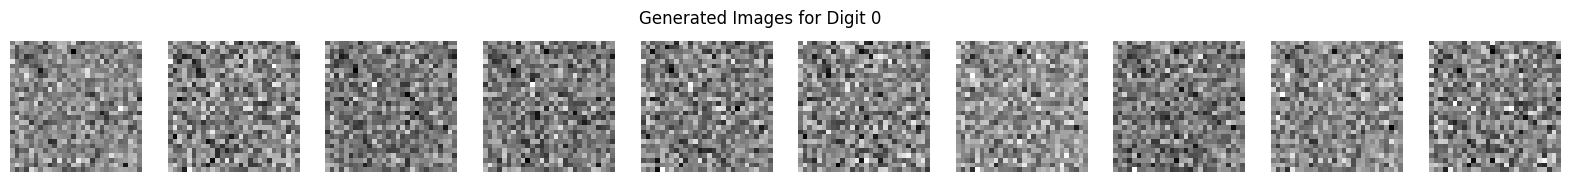

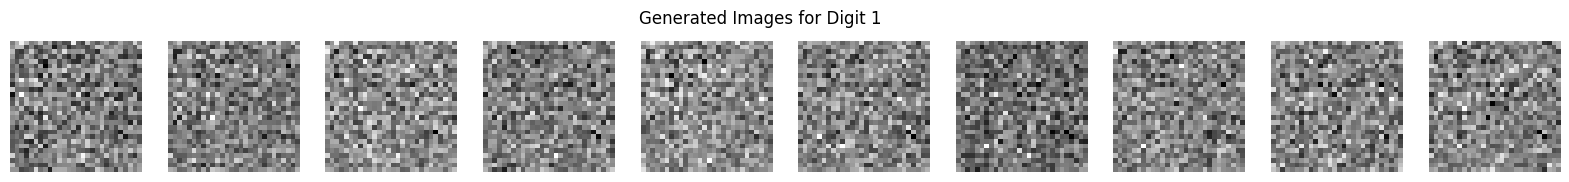

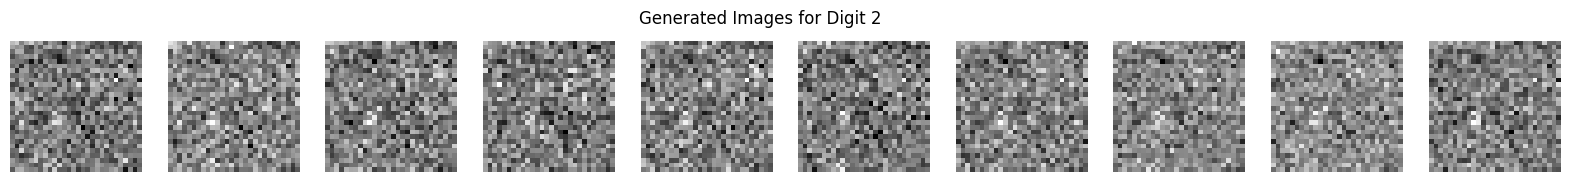

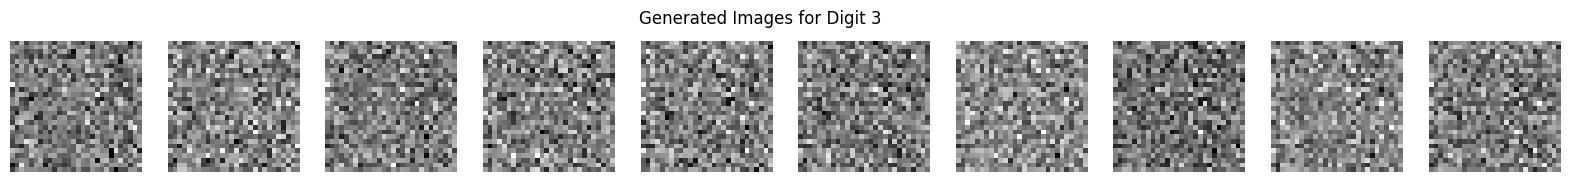

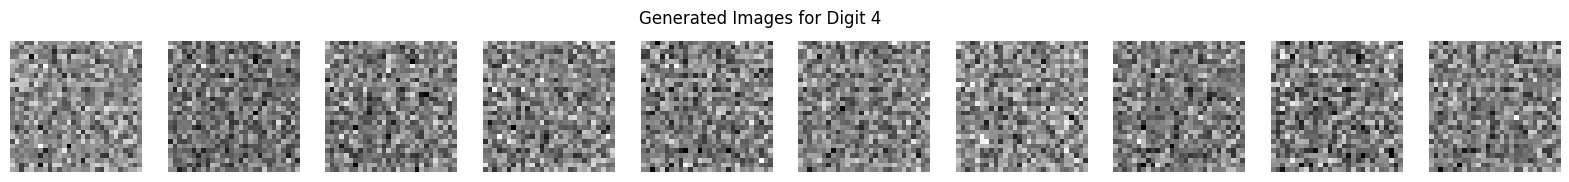

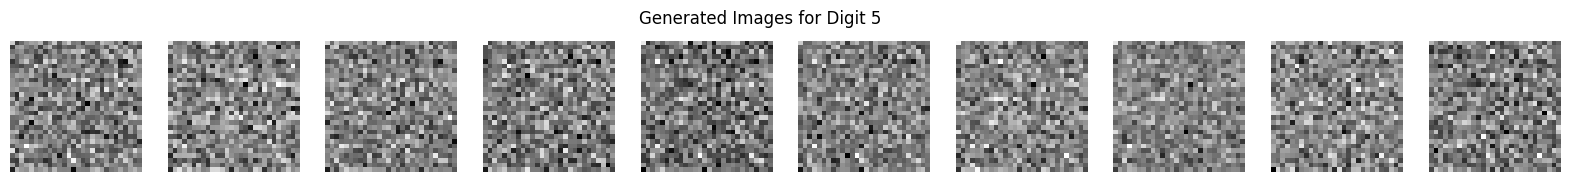

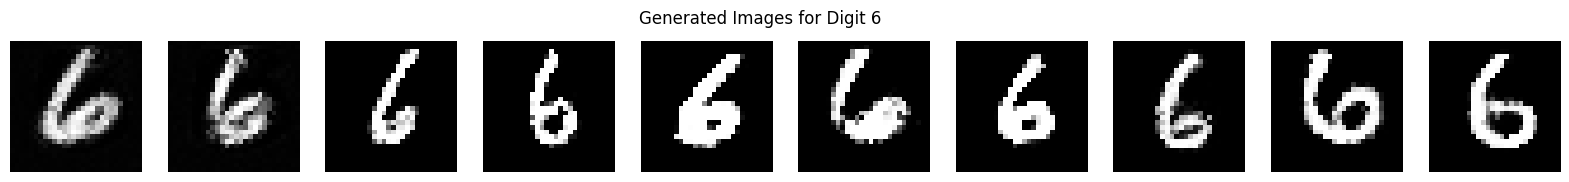

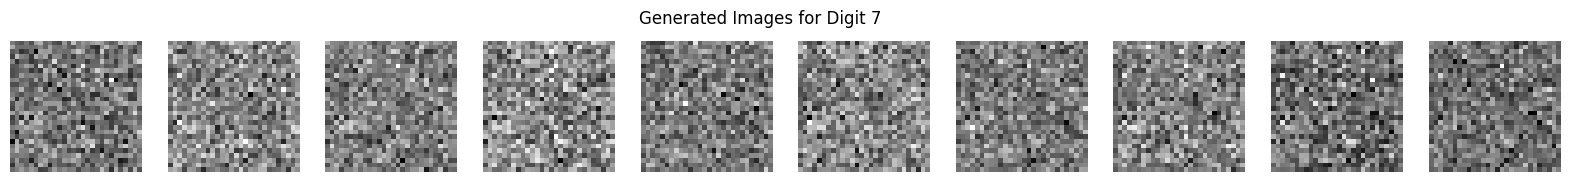

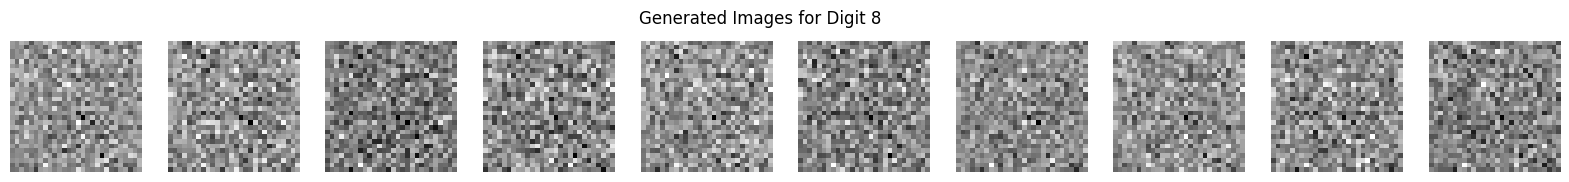

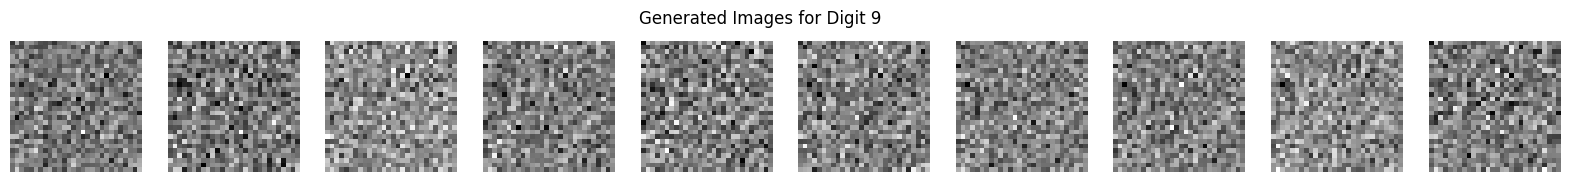

In [ ]:
# Generate and display images for each digit
for i, model in enumerate(models):
    generate_images(model, digit=i)
    

In [ ]:


# Example usage
# Assuming `samples` are your generated samples and `data` is the dataset you want to evaluate
sigma_range = np.arange(0.1, 0.5, 0.05)  # Adjust this as necessary

target_digit = 0 



model = models[target_digit]
noise = tf.random.normal([data.shape[0], 100])
samples = model(noise)

best_log_likelihood, best_sigma = find_best_sigma(samples, data, sigma_range)
print(f"Best Sigma: {best_sigma}, Log Likelihood: {best_log_likelihood.numpy()}")


NameError: name 'data' is not defined